In [2]:
# Step 1: Install fastai if needed
# Uncomment the following line if fastai is not installed
# !pip install fastai

# Step 2: Import necessary libraries


from fastai.vision.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [3]:

# Step 3: Load the CSV file containing control data
controls = pd.read_csv('data/controls.csv')

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 741 entries, 0 to 740
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   frame     741 non-null    object
 1   steering  741 non-null    int64 
 2   throttle  741 non-null    int64 
 3   brake     741 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 23.3+ KB
None

Summary Statistics:
         steering    throttle  brake
count  741.000000  741.000000  741.0
mean     0.074224    0.967611    0.0
std      0.502585    0.177150    0.0
min     -1.000000    0.000000    0.0
25%      0.000000    1.000000    0.0
50%      0.000000    1.000000    0.0
75%      0.000000    1.000000    0.0
max      1.000000    1.000000    0.0


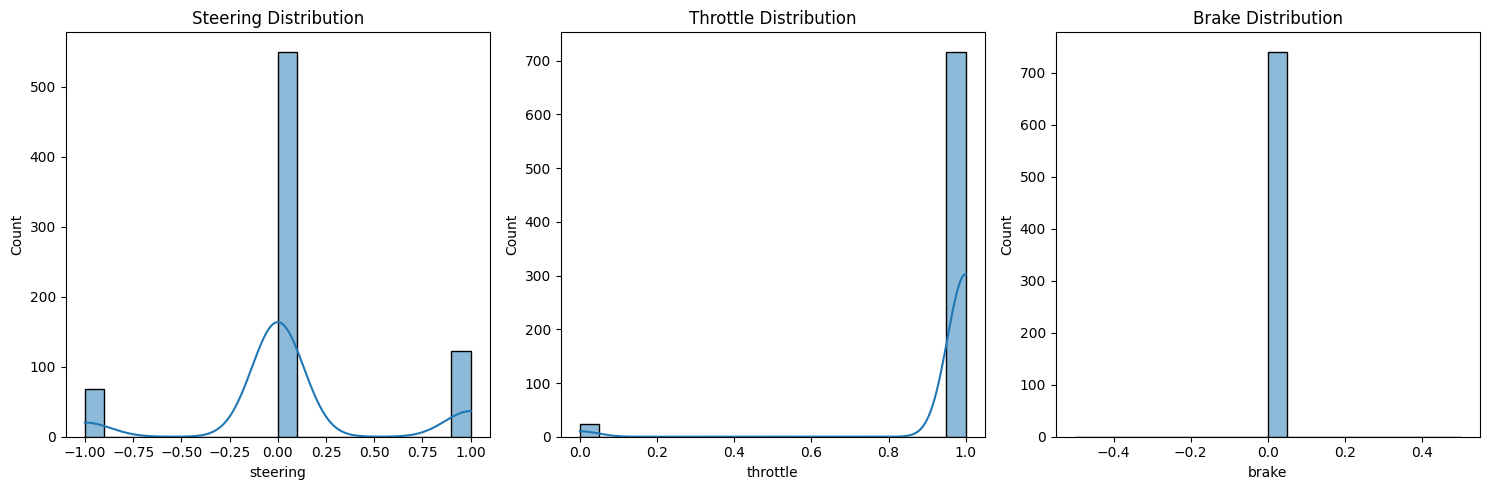

In [4]:
# Step 4: Perform EDA (Exploratory Data Analysis)
# Display basic info about the dataset
print("Data Information:")
print(controls.info())

# Display summary statistics for the control values
print("\nSummary Statistics:")
print(controls.describe())

# Visualize distributions of the control values (steering, throttle, brake)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(controls['steering'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Steering Distribution')

sns.histplot(controls['throttle'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Throttle Distribution')

sns.histplot(controls['brake'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Brake Distribution')

plt.tight_layout()
plt.show()

In [5]:
#  Step 5: Define the DataBlock for fastai with preprocessing and augmentation
driving_block = DataBlock(
    blocks=(ImageBlock, RegressionBlock(n_out=3)),  # Image inputs, 3 continuous outputs
    get_x=ColReader('frame', pref='data/'),  # Load images from the 'data' directory
    get_y=ColReader(['steering', 'throttle', 'brake']),  # Get labels from specified columns
    splitter=RandomSplitter(valid_pct=0.2),  # Split data into training and validation sets
    item_tfms=Resize(224),  # Resize all images to 224x224 for training
    batch_tfms=aug_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1, max_warp=0.2)
)


In [6]:
# Step 6: Create DataLoaders
dls = driving_block.dataloaders(controls, bs=64)  # Adjust batch size as needed


In [7]:
# Step 6: Define a Basic Custom CNN Model with Dropout and Sigmoid
def create_cnn_model():
    return nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Input: 3 channels, 16 filters
        nn.ReLU(),
        nn.MaxPool2d(2),  # Downsample by 2
        nn.Dropout(0.25),  # Dropout with a probability of 0.25
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 32 filters
        nn.ReLU(),
        nn.MaxPool2d(2),  # Downsample again
        nn.Dropout(0.25),  # Dropout with a probability of 0.25
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Dropout(0.5),  # Dropout with a probability of 0.5 before the dense layer
        nn.Linear(64 * 28 * 28, 512),  # Adjust based on input size (e.g., 28x28 if using Resize(224))
        nn.ReLU(),
        nn.Dropout(0.5),  # Dropout with a probability of 0.5 before the output layer
        nn.Linear(512, 3),  # Output layer: 3 units for steering, throttle, brake
        nn.Sigmoid()  # Apply sigmoid to constrain the output between 0 and 1
    )

In [8]:
# Step 7: Create a learner with the custom CNN model, using weight decay for L2 regularization
learn = Learner(
    dls, 
    create_cnn_model(), 
    loss_func=MSELossFlat(), 
    metrics=rmse, 
    wd=1e-4  # Weight decay (L2 regularization)
)

In [9]:
# Step 7: Define the DataBlock for fastai
driving_block = DataBlock(
    blocks=(ImageBlock, RegressionBlock(n_out=3)),  # Image inputs, 3 continuous outputs
    get_x=ColReader('frame', pref='data/'),  # Load images from the 'data' directory
    get_y=ColReader(['steering', 'throttle', 'brake']),  # Get labels from specified columns
    splitter=RandomSplitter(valid_pct=0.2),  # Split data into training and validation sets
    item_tfms=Resize(224),  # Resize all images to 224x224 for training
    batch_tfms=aug_transforms(do_flip=True, flip_vert=False, max_rotate=10, max_zoom=1.1)
)

C:\Users\alame\AppData\Roaming\Python\Python312\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=devic

SuggestedLRs(valley=0.0020892962347716093)

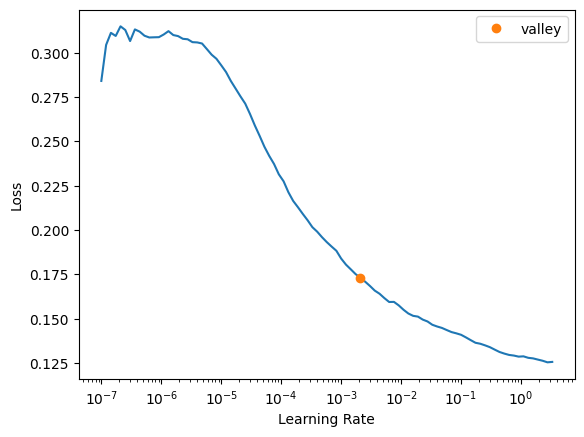

In [10]:
# Step 8: Find the optimal learning rate
learn.lr_find()
# Use the valley learning rate from the plot

In [ ]:
# Step 9: Train the model with the optimal learning rate using advanced techniques
learn.fit_one_cycle(10, lr_max=3e-4)  # Adjust the number of epochs and learning rate based on lr_find()


epoch,train_loss,valid_loss,_rmse,time
0,0.208734,0.133234,0.365012,00:33


In [ ]:
# Step 10: Fine-tune the model further with differential learning rates
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5, 3e-4))

In [ ]:
# Step 11: Evaluate the model's performance on the validation set
learn.show_results(max_n=5)
val_rmse = learn.validate()
print(f"Validation RMSE: {val_rmse}")

In [1]:
# Step 12: Save the trained model for future use
learn.save('custom-cnn-autonomous-driving-model-with-sigmoid')

# Step 13: Load the saved model (for inference)
learn = learn.load('custom-cnn-autonomous-driving-model-with-sigmoid')

# Step 14: Predict control values for a new image
img = PILImage.create('data/frame_100.jpg')  # Replace with your image path
pred = learn.predict(img)
print(f"Predicted Steering: {pred[0][0]}, Throttle: {pred[0][1]}, Brake: {pred[0][2]}")

NameError: name 'learn' is not defined